<a href="https://colab.research.google.com/github/bmjaron/capstone/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Overview

# II. Business Understanding

Despite living in a world with convenient online access to information and news, [this](https://www.nngroup.com/articles/how-people-read-online/) report from the Nielsen Norman Group has shown the most readers do not read online. This is because humans still prefer articles that conform with their personal preferences, and find searching for and reading articles online to be a waste of time. A [second](https://www.orientation.agency/insights/how-people-read-online) report from Orientation shows similar findings, and highlights that users only spending about 15 seconds on a given web page before moving on.

As a result of this predicament, there is to build technology to hand-pick online articles to provide readers with the content they need without wasting time.

Our target clientele are those who work in the politics, lobbyists, think tank employees, or any other individual that must read political articles for their work. In contrast to those who skim the news in their spare time, these individuals must be current with political news in order to properly perform their jobs. As such, it is necessary for them to be able to identify political articles and discard unrelated and distracting content.

Our goal is to build a model that can predict a political article given a short description of that model. This will in turn provide our cleints with the ability to pin-down their required reading with efficiency.

# III. Data Understanding

First we'll import our libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
import string
from wordcloud import WordCloud

#NLTK
import nltk
from nltk.collocations import *
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Our data comes from Kaggle ([linked here](https://www.kaggle.com/datasets/rmisra/news-category-dataset)). We want anyone who reproduces this code to be able to access the data using just their Kaggle username and API key.

In [58]:
username = input("Enter username:")

key = input("Enter API key:")

Enter username:
Enter API key:


In [3]:
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':f"{username}" ,
'key':f"{key}"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [4]:
import kaggle


In [5]:
!kaggle datasets download -d rmisra/news-category-dataset

 94% 25.0M/26.5M [00:02<00:00, 13.5MB/s]
100% 26.5M/26.5M [00:02<00:00, 11.1MB/s]


In [6]:
!unzip /content/news-category-dataset.zip

Archive:  /content/news-category-dataset.zip
  inflating: News_Category_Dataset_v3.json  


In [7]:
#Load .json file
df = pd.read_json("/content/News_Category_Dataset_v3.json", lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [8]:
df.shape

(209527, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [10]:
df['category'].value_counts().head()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: category, dtype: int64

In [11]:
len(df['category'].value_counts())

42

We can see that our data set contains 209,527 news articles from the Huffington Post. Each entry is a different article containing a link, headline, category, short description, authors and date. There are 42 distinct categories of articles.

We find this data set incredibly suitable for our business problem. It is a large set, containing many political articles. There are also many various categories of articles that will enable us to train a model that can predict a political article.

One particular point of difficulty may be the overwhelming number of categories. This makes it harder to build a multi-class predictor, and will require us to engineer this dataset into smaller classes of categories.

# IV. EDA

To begin, we'll look at the different categories of news articles and their counts.

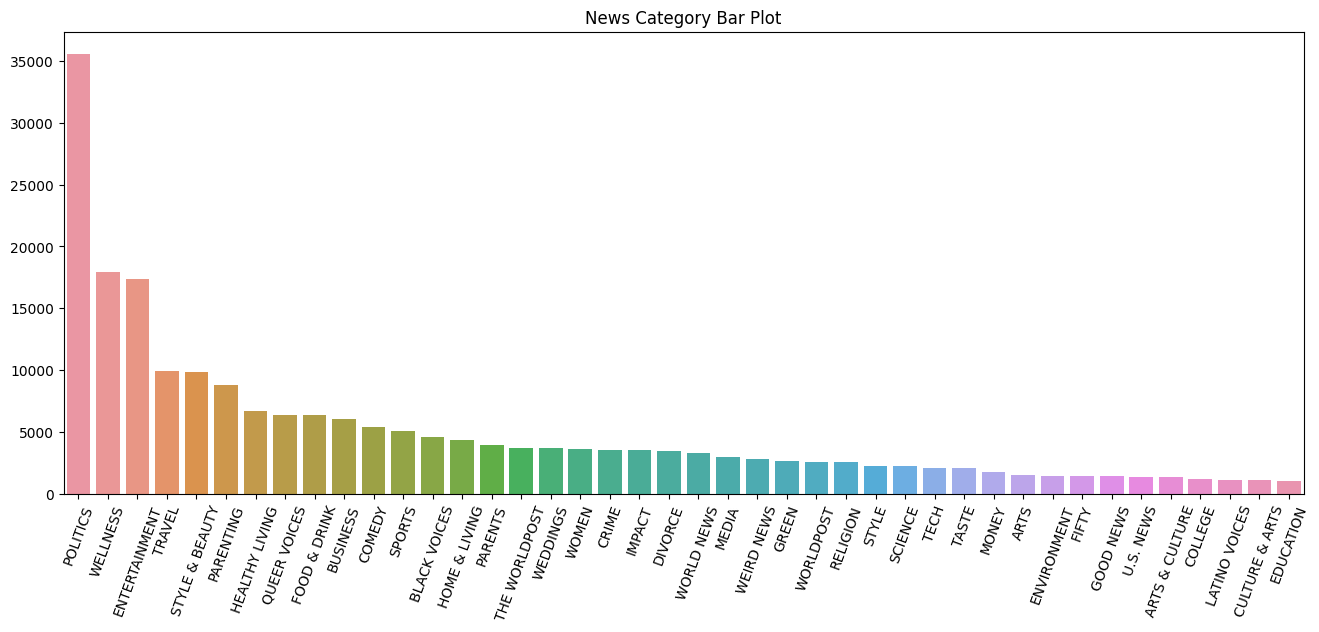

In [12]:
fig, ax = plt.subplots(figsize=(16,6))

#Barplot of different categories
sns.barplot(x=df['category'].value_counts().index,
            y=df['category'].value_counts().values)

plt.title("News Category Bar Plot")
#Rotate x-labels for visibility
plt.xticks(rotation=70);

As our goal is to predict politics articles, we'll dive into some politics specific EDA. We'll being by looking at the common authors of political articles.

In [13]:
#Separate politics from rest of data frame
df_politics = df[df['category'] == 'POLITICS']

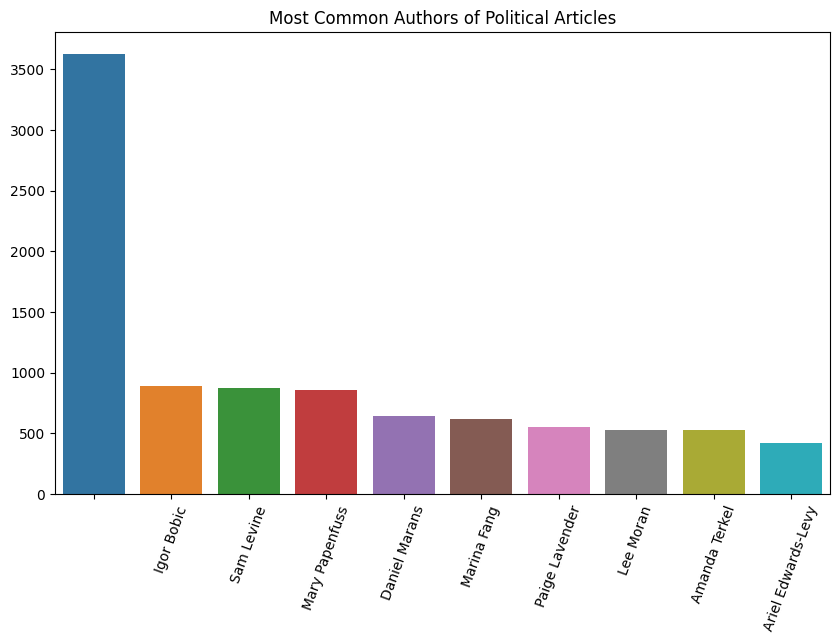

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

#Barplot of different categories
sns.barplot(x=df_politics['authors'].value_counts().head(10).index,
            y=df_politics['authors'].value_counts().head(10).values)

plt.title("Most Common Authors of Political Articles")
#Rotate x-labels for visibility
plt.xticks(rotation=70);

What stands out is that most articles do not have an author. A link to an explanation [here](https://www.quora.com/Why-do-many-BBC-articles-lack-authors) notes that oftentimes a news companies stake their reputations on the veracity of their article. As a result, the company omits an author in order to demonstrate that the article is the collective view of the company. Additionally, it could be that the entire politics team writes certain parts and there is no specific author.

# V. Two class classification

As an introduction, we're going to begin with a 2-class classification problem. We'll split the data frame into 2 categories, politics (1) or non-politics (0).

In [15]:
#Make a copy that will be the cleaned data frame
df_1 = df.copy()

## B. Text Cleaning

To begin, we must prepare our text data for modeling. We'll start by creating a function to clean text ([link](https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model) to author of these regular expressions).

In [16]:
def text_cleaning(text):
  #Lowercase
  text = text.lower()
  #Strip punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('’\S+', '', text)
  text = re.sub('“\S+', '', text)
  text = re.sub('”\S+', '', text)
  return text

In [17]:
#Map function on article descriptions
df_1['short_description'] = df_1['short_description'].map(lambda x: text_cleaning(x))

Tokenize the text.

In [18]:
#Map NLTK tokenizer on text
df_1['short_description'] = df_1['short_description'].map(lambda x: nltk.word_tokenize(x))

Stopword, stemming and lemmetization.

In [19]:
#Store English stopwords as object
stop_words = stopwords.words('english')

#Extract only words not in stopwords
df_1['short_description'] = df_1['short_description'].map(lambda x: [word for word in x if word not in stop_words])

In [20]:
#Stem using Porter Stemmer
from nltk import PorterStemmer

stemmer = PorterStemmer()

#Map stemmer on df
df_1['short_description'] = df_1['short_description'].map(lambda x: [stemmer.stem(word) for word in x])

In [21]:
#Lemmatize using NLTK's WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

#Map
df_1['short_description'] = df_1['short_description'].map(lambda x: [wnl.lemmatize(word) for word in x])

Now, let's quickly preview our work.

In [22]:
df_1[['short_description']].head()

,short_description
0,"[health, expert, said, earli, predict, whether..."
1,"[subdu, passeng, crew, fled, back, aircraft, c..."
2,"[dog, dont, understand, could, eaten]"
3,"[accident, put, grownup, toothpast, toddler, t..."
4,"[ami, cooper, accus, invest, firm, franklin, t..."


This looks good. We will want to reuse this cleaned and tokenized data for our multiple class classification problem also. As such, we're going make a unique copy for this 2-class problem. Additionally, we're going to convert every article to either one of two categories: politics (1) and non-politics (0).

In [23]:
#Make copy
df_2c = df_1.copy()

#Convert every category into politics (1) or not politics (0)
df_2c['category'] = df_2c['category'].map(lambda x: 1 if x == 'POLITICS' else 0)


To get an image of the great class imbalance, let's plot it below.

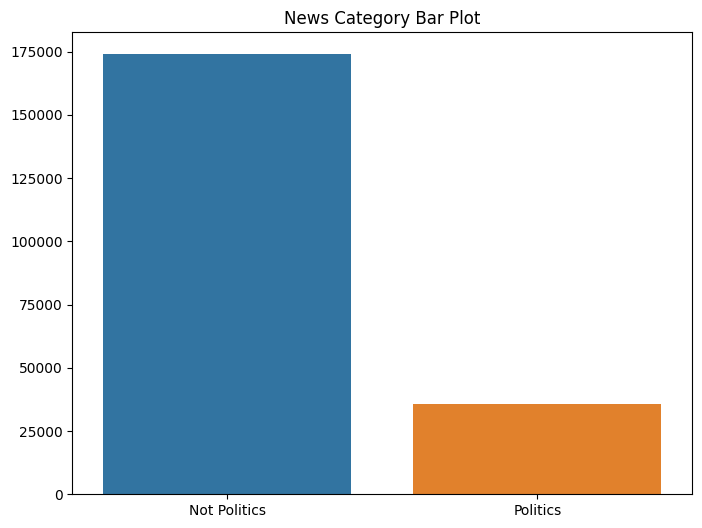

In [24]:
#Plot imbalance
fig, ax = plt.subplots(figsize=(8,6))

#Barplot of different categories
sns.barplot(x=['Not Politics', 'Politics'],
            y=df_2c['category'].value_counts().values)

plt.title("News Category Bar Plot");

## C. Histograms and More EDA

Now that we have our data cleaned and tokenized, let's check out some histograms and such.

In [25]:
#Import necessary function from NLTK
from nltk.probability import FreqDist

In [26]:
#Make list of corpus words
corpus_words = [word for desc in df_2c['short_description'] for word in desc]

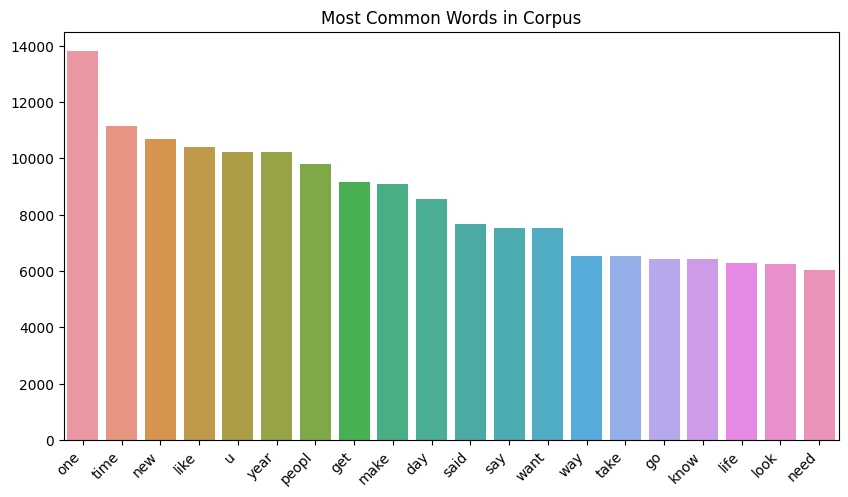

In [27]:
#Get the 20 most commmon words in our data set
corpus_fdist = FreqDist(corpus_words).most_common(20)

#Plot
fig, ax = plt.subplots(figsize=(10,6))
fig.autofmt_xdate(rotation=45)

sns.barplot(x=[tup[0] for tup in corpus_fdist],
            y=[tup[1] for tup in corpus_fdist],
            ax=ax).set(title='Most Common Words in Corpus');

This is not particularly enlightening. These are some of the more common words in the English language, and could be expected to be the most common words in article descriptions.

Next, we'll compare histograms of most common words, per category.

In [28]:
#Make word corpuses for category
politics_words = [word for desc in df_2c[df_2c['category'] == 1]['short_description'] for word in desc]
non_politics_words = [word for desc in df_2c[df_2c['category'] == 0]['short_description'] for word in desc]

In [29]:
#Make and plot histograms
politics_fdist = FreqDist(politics_words).most_common(20)
non_politics_fdist = FreqDist(non_politics_words).most_common(20)


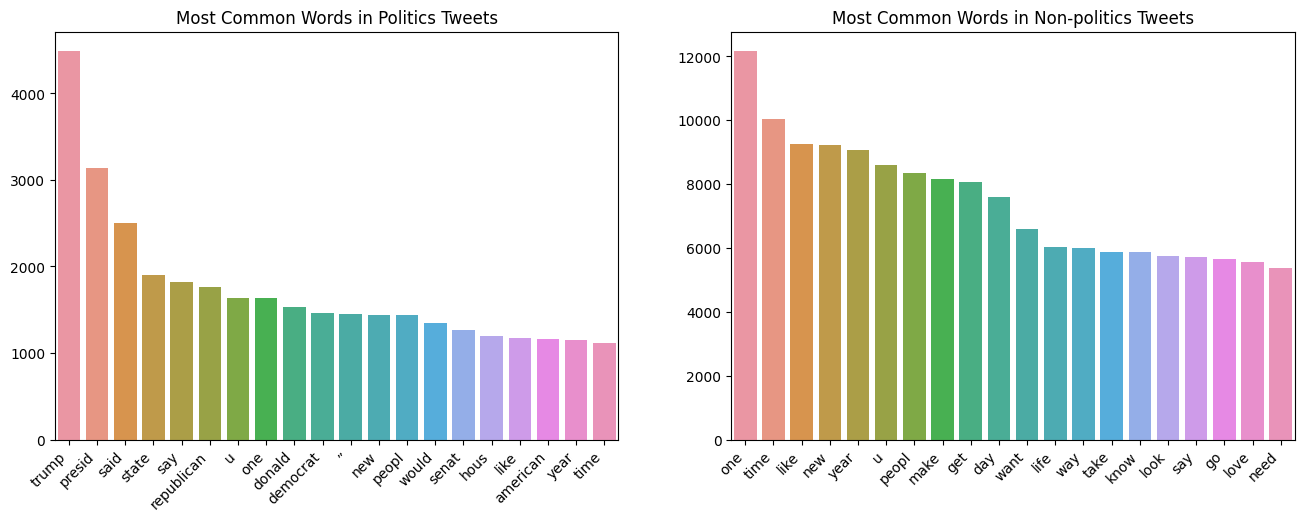

In [30]:
#Plot side by side
fig, axes = plt.subplots(1,2, figsize=(16, 6))
fig.autofmt_xdate(rotation=45)

sns.barplot(x=[tup[0] for tup in politics_fdist],
            y=[tup[1] for tup in politics_fdist],
            ax=axes[0]).set(title='Most Common Words in Politics Tweets');

sns.barplot(x=[tup[0] for tup in non_politics_fdist],
            y=[tup[1] for tup in non_politics_fdist],
            ax=axes[1]).set(title='Most Common Words in Non-politics Tweets');

This is very promising. We see that political articles have words that are extremely unique to that class; including Donald Trump, president, democrat, etc. It is needless to say that these words will be valuable predictors for the model.

## D. Initial Modeling

Split data into training, testing and holdout sets.

In [31]:
#Set the short description as the predictor and category as target
X = df_2c[['short_description']]
y = df_2c['category']

In [32]:
#Import train/test split
from sklearn.model_selection import train_test_split

#Split holdout set
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=0)

#Spit training set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)

We noted above that we have severe imbalance. As such, we're going to randomly undersample the majority class and make perfectly even classes.

In [33]:
from imblearn.under_sampling import RandomUnderSampler

#Instantiate sampler with 1:1 strategy
rus = RandomUnderSampler(sampling_strategy=1, random_state=0)

#Fit and resample our training data
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In order to prepare our text data for modeling, we must have it in vector form. We're going to use the TF-IDF vectorizer, as it places greater weight on category-specific words by penalizing common words accross the corpus.

In [34]:
#Import vectorizer from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
#Instantiate
vectorizer = TfidfVectorizer()

In [36]:
#Return single sentences as opposed to lists of tokenized words for the vectorizer
X_train_rus_vectorized = X_train_rus['short_description'].map(lambda x: ' '.join(word for word in x))
X_test_vectorized = X_test['short_description'].map(lambda x: ' '.join(word for word in x))

#Fit on training set and transform both training and testing sets
X_train_rus_vec = vectorizer.fit_transform(X_train_rus_vectorized)
X_test_vec = vectorizer.transform(X_test_vectorized)

In [37]:
#Put respective vectors into data frame form
X_train_rus_vectorized = pd.DataFrame(data = X_train_rus_vec.toarray(),
                                      columns = vectorizer.get_feature_names_out())
X_test_vectorized = pd.DataFrame(data = X_test_vec.toarray(),
                                 columns = vectorizer.get_feature_names_out())

#Set index to the article description
X_train_rus_vectorized.index = X_train_rus['short_description']
X_test_vectorized.index = X_test['short_description']


### i. Baseline logistic regression

In [38]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train_rus_vectorized, y_train_rus)

LogisticRegression()

In [39]:
y_train_pred_1 = lr.predict(X_train_rus_vectorized)
y_test_pred_1 = lr.predict(X_test_vectorized)

In [40]:
from sklearn.metrics import classification_report

print("Training Classification Report")
print(classification_report(y_train_rus, y_train_pred_1))
print()
print("--------------------------------------------------------")
print()
print("Testing Classification Report")
print(classification_report(y_test, y_test_pred_1))

Training Classification Report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     19953
           1       0.89      0.77      0.83     19953

    accuracy                           0.84     39906
   macro avg       0.84      0.84      0.84     39906
weighted avg       0.84      0.84      0.84     39906


--------------------------------------------------------

Testing Classification Report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     32607
           1       0.51      0.72      0.60      6680

    accuracy                           0.83     39287
   macro avg       0.72      0.79      0.75     39287
weighted avg       0.86      0.83      0.84     39287



Run a naive Bayes' classifier.

### ii. Multinomial Bayes' classifier

In [41]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train_rus_vectorized, y_train_rus)

MultinomialNB()

In [42]:
y_train_pred_2 = mnb.predict(X_train_rus_vectorized)
y_test_pred_2 = mnb.predict(X_test_vectorized)

In [43]:
print("Training Classification Report")
print(classification_report(y_train_rus, y_train_pred_2))
print()
print("--------------------------------------------------------")
print()
print("Testing Classification Report")
print(classification_report(y_test, y_test_pred_2))

Training Classification Report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     19953
           1       0.86      0.80      0.83     19953

    accuracy                           0.83     39906
   macro avg       0.83      0.83      0.83     39906
weighted avg       0.83      0.83      0.83     39906


--------------------------------------------------------

Testing Classification Report
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     32607
           1       0.46      0.76      0.57      6680

    accuracy                           0.81     39287
   macro avg       0.70      0.79      0.73     39287
weighted avg       0.86      0.81      0.83     39287



# VI. Multiclass Classification

## A. Data preparation

In [44]:
df_mc = df_1.copy()

In [45]:
#Preview most common categories
df_mc['category'].value_counts().head()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: category, dtype: int64

To begin we'll break our dataframe into 4 categories. Politics (0), wellness (1), entertainment (2), and all other (3).

In [46]:
#Create function to map onto dataframe
def multiclass_categories(x):
  if x == 'POLITICS':
    cat = 0
  elif x == 'WELLNESS':
    cat = 1
  elif x == 'ENTERTAINMENT':
    cat = 2
  else:
    cat = 3
  return(cat)

df_mc['category'] = df_mc['category'].map(multiclass_categories)

In [47]:
df_mc.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,3,"[health, expert, said, earli, predict, whether...","Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",3,"[subdu, passeng, crew, fled, back, aircraft, c...",Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,3,"[dog, dont, understand, could, eaten]",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,3,"[accident, put, grownup, toothpast, toddler, t...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,3,"[ami, cooper, accus, invest, firm, franklin, t...",Nina Golgowski,2022-09-22


In [48]:
df_mc['category'].value_counts()

3    138618
0     35602
1     17945
2     17362
Name: category, dtype: int64

## B. Modeling

In [49]:
X_mc = df_mc[['short_description']]
y_mc = df_mc['category']

In [50]:
X_mc_train, X_mc_holdout, y_mc_train, y_mc_holdout = train_test_split(X_mc, y_mc, random_state=0)

#Spit train into train and test
X_mc_train, X_mc_test, y_mc_train, y_mc_test = train_test_split(X_mc_train, y_mc_train, random_state=0)

In [51]:
#Find the size of smallest class to determine size of each class
min = y_mc_train.value_counts().min()

rus_mc = RandomUnderSampler(sampling_strategy={0: min, 1: min, 2: min, 3: min}, random_state=0)

X_mc_train_rus, y_mc_train_rus = rus_mc.fit_resample(X_mc_train, y_mc_train)

In [52]:
vectorizer_1 = TfidfVectorizer()

In [53]:
X_mc_train_rus_vectorized = X_mc_train_rus['short_description'].map(lambda x: ' '.join(word for word in x))
X_mc_test_vectorized = X_mc_test['short_description'].map(lambda x: ' '.join(word for word in x))

X_mc_train_rus_vec = vectorizer_1.fit_transform(X_mc_train_rus_vectorized)
X_mc_test_vec = vectorizer_1.transform(X_mc_test_vectorized)

In [54]:
X_mc_train_rus_vectorized = pd.DataFrame(data = X_mc_train_rus_vec.toarray(),
                                         columns = vectorizer_1.get_feature_names_out())
X_mc_test_vectorized = pd.DataFrame(data = X_mc_test_vec.toarray(),
                                    columns = vectorizer_1.get_feature_names_out())

X_mc_train_rus_vectorized.index = X_mc_train_rus['short_description']
X_mc_test_vectorized.index = X_mc_test['short_description']

### ii. MNB classifier

In [55]:
mnb_2 = MultinomialNB()

mnb_2.fit(X_mc_train_rus_vectorized, y_mc_train_rus)

MultinomialNB()

In [56]:
y_mc_train_pred_2 = mnb_2.predict(X_mc_train_rus_vectorized)
y_mc_test_pred_2 = mnb_2.predict(X_mc_test_vectorized)

In [57]:
print("Training Classification Report")
print(classification_report(y_mc_train_rus, y_mc_train_pred_2))
print()
print("--------------------------------------------------------")
print()
print("Testing Classification Report")
print(classification_report(y_mc_test, y_mc_test_pred_2))

Training Classification Report
              precision    recall  f1-score   support

           0       0.66      0.86      0.74      9776
           1       0.71      0.93      0.81      9776
           2       0.84      0.62      0.71      9776
           3       0.78      0.51      0.61      9776

    accuracy                           0.73     39104
   macro avg       0.75      0.73      0.72     39104
weighted avg       0.75      0.73      0.72     39104


--------------------------------------------------------

Testing Classification Report
              precision    recall  f1-score   support

           0       0.41      0.79      0.54      6680
           1       0.27      0.90      0.41      3342
           2       0.33      0.52      0.41      3241
           3       0.90      0.35      0.50     26024

    accuracy                           0.49     39287
   macro avg       0.48      0.64      0.47     39287
weighted avg       0.71      0.49      0.49     39287

